# Autoregressive model using a feedforward neural network

In this notebook we will use a feedforward neural network to fit a linear model to time series data. 

<div class="alert alert-success">
    
1. The data preprocessing requirements for a NN are similar to those of an OLS.

2. Forecasting **h-steps** ahead can use either an iterative or direct method.
</div>

---
**LEARNING OBJECTIVES**

* Use a NN to mimic a linear model
* Generate h-step forecasts using an iterative approach
* Generate h-step forecast using a direct modelling approach
* Construct a deep feedforward neural network for forecasting
* Use a ensemble of neural networks to forecast
---


## 1. Python dependencies

It is recommended that you use the forecasting course conda environment provided for this work. We are going to implement neural networks using `tensorflow` and '`keras`. You should be using at least `tensorflow` version `2.1.0`.

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#tensorflow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping



tf.__version__

'2.1.0'

## 2. Reminder: The forecasting process for AR

1. Select $l$ the number of autoregressive lags and forecast horizon $h$
2. Preprocess the data into tabular form [[$lag_1, lag_2, ... lag_l$], [$y_t$]]
3. Train the NN model using the tabular data
4. Iteratively forecast 1-step ahead gradually replacing ground truth observations with predictions.


### 2.1 Synthetic data without noise

Given the extra complexities of forecasting using OLS we will use simple synthetic data before exploring real healthcare data. The synthetic data we wil use is a cosine.  

In [2]:
t = np.arange(200)
ts_data = np.cos(0.2 * t)

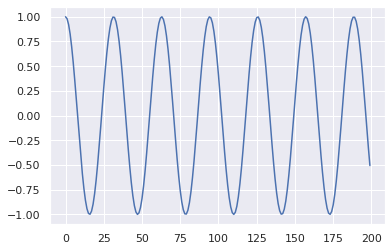

In [3]:
plt.plot(ts_data);

## 2.2. Preprocess the time series into tabular autoregressive form

An autoregressive model consists of $l$ lags of the time series. 

An easy way to think about the form of the data for a autoregressive OLS model is as a table of variables.  The first $l$ columns are the lags (the independent predictor variables) and the final column is $y$ at time $t$ ($y_t$) that is, the target/dependent variable.  

We there need to manipulate the time series so that is now in that format.  More precisely for each row we need: 

**A vector presenting the lags at time t**
* $X_t = $ [$lag_{t-l}, ... lag_{t-2}, lag_{t-1}$]

**A scalar value representing y at time t:**
* $y_t$

For training we need a vector of rows ($X_t$) and vector of target $y_t$. e.g.

```python
X_train = [X_1, X_2, X_3, ...,  X_t]

y_train = [y_1, y_2, y_3, ..., y_t]
```
---

The function `sliding_window` illustrates how to preprocess time series data into tabular form  in python.

In [4]:
def sliding_window(train, window_size=2, horizon=1):
    '''
    sliding window.
    
    Parameters:
    --------
    train: array-like
        training data for time series method
    
    window_size: int, optional (default=2)
        lookback - how much lagged data to include.
        
    horizon: int, optional (default=1)
        number of observations ahead to predict
            
    Returns:
        array-like, array-like
    
        preprocessed X, preprocessed Y
    '''
    tabular_X = []
    tabular_y = []
    
    for i in range(0, len(train) - window_size - horizon):
        X_train = train[i:window_size+i]
        y_train = train[i+window_size+horizon-1]
        tabular_X.append(X_train)
        tabular_y.append(y_train)
       
    return np.asarray(tabular_X), np.asarray(tabular_y).reshape(-1, )

In [5]:
#preprocess time series training and test sets
X_train, y_train = sliding_window(ts_data, window_size=2)

training_length = int(len(y_train) * (2/3))

X_train, X_test = X_train[:training_length], X_train[training_length:]
y_train, y_test = y_train[:training_length], y_train[training_length:]
print(X_train.shape, y_train.shape)

(131, 2) (131,)


<div class="alert alert-info">
    
If you need a reminder of what the preprocessing does to the data please look back to the OLS notebook.  Here is the result of the preprocessing as a **pandas.DataFrame**.  This looks just like cross-sectional data that you would use to train a conventional NN.
</div>



In [10]:
tabular_form = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
columns = [f'lag_{i}' for i in range(len(X_train[0]), 0, -1)]
columns.append('y_t')
tabular_form.columns = columns
tabular_form.head()

,lag_2,lag_1,y_t
0,1.000000,0.980067,0.921061
1,0.980067,0.921061,0.825336
2,0.921061,0.825336,0.696707
3,0.825336,0.696707,0.540302
4,0.696707,0.540302,0.362358


## 2.3 Train the NN using the preprocessed series

After preprocessing the data, fitting the data is relatively straightforward.  We create an instance of `OLS` passing in the training data and call the `.fit()` method.  The method fit returns a `RegressionResults` object that we use for prediction.  We can called the `.summary()` method to see the fitted model.

In [11]:
def get_linear_model(ws, lr=0.01, metrics=None):
    if metrics is None:
        metrics = ['mae', 'mse']
    
    model = Sequential([Dense(1, input_shape=(ws,))])
    model.compile(loss='mse', 
                  optimizer=Adam(lr=lr),
                  metrics=metrics)
    
    return model

In [12]:
N_EPOCHS = 100
WINDOW_SIZE = 5
es = EarlyStopping(monitor='val_loss', patience=3)

#pre-process the data into sliding windows
X_train, y_train = sliding_window(ts_data, window_size=WINDOW_SIZE)

#train test split
training_length = int(len(y_train) * (2/3))
X_train, X_test = X_train[:training_length], X_train[training_length:]
y_train, y_test = y_train[:training_length], y_train[training_length:]

#compile the tf model
model = get_linear_model(WINDOW_SIZE)

history = model.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[es])

Train on 129 samples, validate on 65 samples
Epoch 1/100
129/129 [==============================] - 1s 6ms/sample - loss: 0.5849 - mae: 0.6889 - mse: 0.5849 - val_loss: 0.5627 - val_mae: 0.6777 - val_mse: 0.5627
Epoch 2/100
129/129 [==============================] - 0s 511us/sample - loss: 0.5336 - mae: 0.6575 - mse: 0.5336 - val_loss: 0.5203 - val_mae: 0.6519 - val_mse: 0.5203
Epoch 3/100
129/129 [==============================] - 0s 387us/sample - loss: 0.4939 - mae: 0.6331 - mse: 0.4939 - val_loss: 0.4814 - val_mae: 0.6270 - val_mse: 0.4814
Epoch 4/100
129/129 [==============================] - 0s 321us/sample - loss: 0.4590 - mae: 0.6100 - mse: 0.4590 - val_loss: 0.4480 - val_mae: 0.6043 - val_mse: 0.4480
Epoch 5/100
129/129 [==============================] - 0s 502us/sample - loss: 0.4268 - mae: 0.5869 - mse: 0.4268 - val_loss: 0.4180 - val_mae: 0.5833 - val_mse: 0.4180
Epoch 6/100
129/129 [==============================] - 0s 500us/sample - loss: 0.3993 - mae: 0.5674 - mse: 0.399

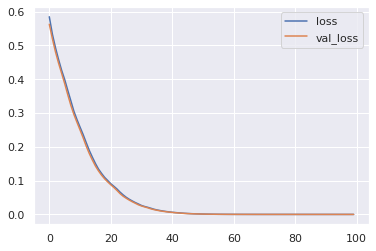

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

## 2.4 Forecasting 1 step ahead

To forecast 1-step ahead we use the `RegressionResults` method `.predict(exog)`.  For example if we wanted to forecast the first y observation in the test set.

In [14]:
X_test[0]

array([0.78552098, 0.64691932, 0.48252703, 0.29889791, 0.10335267])

In [15]:
pred = model.predict(x=X_test[0].reshape(1, -1))[0,0]
print(f'1-step forecast: {pred}')
print(f'ground trust value: {y_test[0]}')

1-step forecast: -0.09627997130155563
ground trust value: -0.09631291684576058


## 2.4 Forecast h periods ahead using the iterative method.

**We have trained our `NN` model to predict 1-step**. When forecasting 2 or more steps ahead we still only have five ground truth observations ($lag_1$ ... $lag_5$). This means that when forecasting h-steps ahead we need to do this in a loop where we iteratively replace our ground truth observations with our predictions.

There's an easy way to do this in python using the `np.roll(a, shift)` function.  That shifts everything in the array down by `shift`.  The function is **circular** so the value in element 0 is moved to be the final value in the array.

In [16]:
def autoregressive_iterative_forecast(model, exog, h):
    '''
    h-step forecast for an autoregressive 
    model using the iterative prediction method.
    
    Conduct h one-step forecasts gradually
    replacing ground truth autoregressive X 
    values with predictions.
    
    Parameters:
    ------
    model: forecast object
        model that has a .predict(h) interface
        
    exog: array-like
        initial vector of lagged values (X)
    
    h: int
        forecast horizon. assumed to be > 0
    
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    y_preds = []
    current_X = exog
    for i in range(h):
        y_pred = model.predict(current_X.reshape(1, -1), 
                               use_multiprocessing=True)[0,0]
        y_preds.append(y_pred)

        current_X = np.roll(current_X, shift=-1)
        current_X[-1] = y_pred

    return np.array(y_preds)

In [17]:
H = 5
y_preds = autoregressive_iterative_forecast(model, X_test[0], h=H)
print(f'Iterative forecast: {y_preds}')
print(f'Ground truth y: {y_test[:H].T}')

Iterative forecast: [-0.09627997 -0.29208922 -0.4762439  -0.64139694 -0.7809713 ]
Ground truth y: [-0.09631292 -0.29213881 -0.47631805 -0.64150799 -0.78112303]


#### Adding some noise

To make this a bit more interesting we will add some normally distributed noise to the synthetic time series.

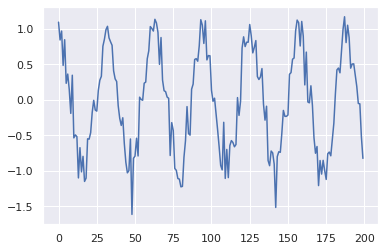

In [18]:
#set the random seed so that we all get the same results
np.random.seed(12)
t = np.arange(200)
ts_data = np.cos(0.2 * t)
noise = np.random.normal(loc=0.0, scale=0.2, size=200)
ts_data = ts_data + noise
plt.plot(ts_data);

In [19]:
#set tensorflow random seed
tf.random.set_seed(1234)

N_EPOCHS = 100
WINDOW_SIZE = 12
es = EarlyStopping(monitor='val_loss', patience=10)

#preprocess time series training and test sets
X_train, y_train = sliding_window(ts_data, window_size=WINDOW_SIZE)

training_length = 130

#train-test split
X_train, X_test = X_train[:training_length], X_train[training_length:]
y_train, y_test = y_train[:training_length], y_train[training_length:]

#compile the tf model
model = get_linear_model(WINDOW_SIZE, metrics=['mse'], lr=0.001)

#fit model silently
history = model.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    callbacks=None)

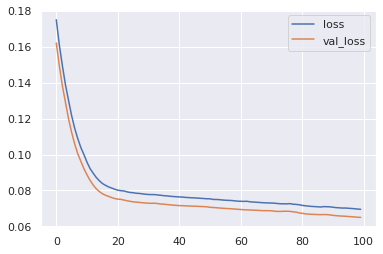

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

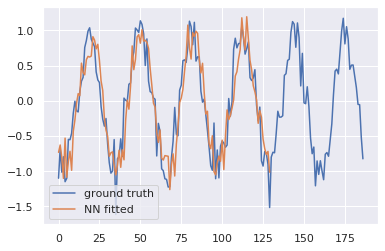

In [21]:
plt.plot(ts_data[WINDOW_SIZE+1:], label='ground truth')
plt.plot(model.predict(X_train), label='NN fitted')
plt.legend();

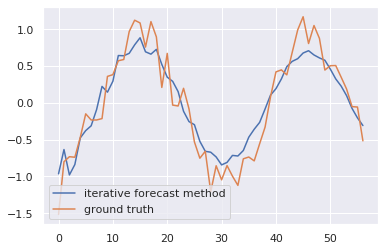

In [22]:
#make iterative predictions
H = len(y_test)
y_preds_iter = autoregressive_iterative_forecast(model, X_test[0], h=H)

#plot
plt.plot(y_preds_iter, label='iterative forecast method')
plt.plot(y_test, label='ground truth')
plt.legend()

In [23]:
len(y_test)

57

##  2.5 The direct h-step forecasting method.

In the direct method to forecast h-steps ahead we have **$h$ forecasting models**.  Each model provides a single point forecast from a step ahead.  In the example here, y_test is of length 57 periods.  The direct method requires 57 NNs to make its prediction!


Recall the `sliding_window` function.  We ignored an optional parameter `horizon` in the iterative example.  By default `horizon=1` i.e. the function returns target values that are only a single period ahead.  We can vary the step size by increasing the value of horizon.  

**Training multiple models**

1. Create a for loop and set it to iterate 57 times. 
2. In each loop call `sliding_window` setting `horizon` to the iteration number + 1
3. Create a new instance of the the model
4. Train the model and save in a list.
5. Save the model to .h5 file. (recommended so you can reload without retraining)

In [20]:
def train_direct_models(data, n_epochs, horizon, window_size, 
                        train_length, save=True):

    models = []

    print('Training model =>', end=' ')
    for h in range(HORIZON):
        print(f'{h+1}', end=', ')
        #preprocess time series training and test sets
        X_train, y_train = sliding_window(ts_data, 
                                          window_size=window_size, 
                                          horizon=h+1)

        #train-test split
        X_train, X_test = X_train[:train_length], X_train[train_length:]
        y_train, y_test = y_train[:train_length], y_train[train_length:]

        #compile the tf model
        model_h = get_linear_model(window_size, metrics=['mse'], lr=0.001)

    
        #fit model silently (verbose=0)
        history_h = model_h.fit(x=X_train, 
                            y=y_train, 
                            epochs=n_epochs,
                            verbose=0)
        
        if save:
            model_h.save(f'./output/direct_model_h{h+1}.h5')

        models.append(model_h)

    print('done')
    return models

In [21]:
def load_models(horizon):
    models = []
    for h in range(HORIZON):
        model_h = tf.keras.models.load_model(f'output/direct_model_h{h+1}.h5')
        models.append(model_h)
    return models

In [22]:
 #set tensorflow random seed
tf.random.set_seed(42)

N_EPOCHS = 100
HORIZON = len(y_test)
WINDOW_SIZE = 12
TRAIN_LENGTH = 130
LOAD_FROM_FILE = True

if LOAD_FROM_FILE:
    direct_models = load_models(HORIZON)
else:
    direct_models = train_direct_models(ts_data, 
                                        n_epochs=N_EPOCHS,
                                        horizon=HORIZON, 
                                        window_size=WINDOW_SIZE, 
                                        train_length=TRAIN_LENGTH)

We now create the `direct_forecast` function.  This is just a for loop to call the `.predict()` method of each model.  Remember that the input to each model is **same** i.e. exog which in our case will be `X_test[0]`

In [23]:
def direct_forecast(models, exog):
    '''
    h-step forecast for an autoregressive 
    model using the direct prediction method.
    
    Each model contained in @models has been trained
    to predict a unique number of steps ahead. 
    Each model forecasts and the results are 
    combined in an ordered array and returned.
    
    Parameters:
    ------
    models: list
        direct models each has has a .predict(exog) 
        interface
        
    exog: array-like
        initial vector of lagged values (X)
        
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    preds = []
    for model_h in models:
        pred_h = model_h.predict(x=exog.reshape(1, -1), 
                                 use_multiprocessing=True)[0, 0]
        preds.append(pred_h)
    
    return np.array(preds)

In [24]:
#make the direct forecast
y_preds_direct = direct_forecast(direct_models, X_test[0])

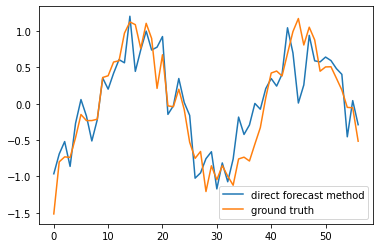

In [25]:
#for clarity repeat the preprocessing
X_train, y_train = sliding_window(ts_data, window_size=WINDOW_SIZE)

#train-test split
X_train, X_test = X_train[:TRAIN_LENGTH], X_train[TRAIN_LENGTH:]
y_train, y_test = y_train[:TRAIN_LENGTH], y_train[TRAIN_LENGTH:]

#plot the direct forecast against the test data
plt.plot(y_preds_direct, label='direct forecast method')
plt.plot(y_test, label='ground truth')
plt.legend()

Like the iterative method the direct method looks a close match to the ground truth test set!  Let's plot all three datasets on the same chart and then take a look at the **RMSE** of each method.

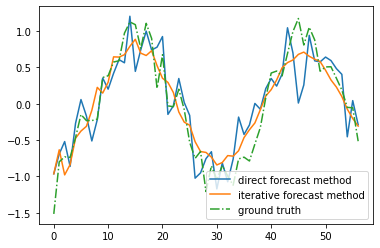

In [27]:
#plot iterative and direct
plt.plot(y_preds_direct, label='direct forecast method')
plt.plot(y_preds_iter, label='iterative forecast method')
plt.plot(y_test, label='ground truth', linestyle='-.')
plt.legend()

In [28]:
from statsmodels.tools.eval_measures import rmse

In [29]:
rmse(y_test, y_preds_iter)

0.2532784783778647

In [30]:
rmse(y_test, y_preds_direct)

0.3175379038168916

In this particular example (and single holdout set) the iterative method out performed the direct method. You should not assume this is always the case!

## 2.6 Forecasting a vector of y

In the **iterative** and **direct** methods we always forecast a *scalar* value.  An modification is to adapt a feedforward neural network to predict a **vector of y values**.  Using this architecture we would train our model on sliding windows of $X$ and $y$.  Where y is a vector of length $h$ and $X$ is a vector of length $ws$ (window size)

### 2.6.1 Exercise: preprocessing the time series into vectors of y
Task: modify the function `sliding_window` (provided below) so that it returns a vectors of y.

Hints:
* Assume you are standing at time $t$. With a forecasting horizon of $h$, y would be $[y_{t+1}, y_{t+2}, ... , y_{t+h}]$.
* Array slicing might prove useful:

```python
train = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(train[2:6])
```
```
>> [3 4 5 6]
```

In [24]:
def sliding_window(train, window_size=2, horizon=2):
    '''
    sliding window.
    
    Parameters:
    --------
    train: array-like
        training data for time series method
    
    window_size: int, optional (default=2)
        lookback - how much lagged data to include.
        
    horizon: int, optional (default=2)
        number of observations ahead to predict
            
    Returns:
        array-like, array-like
    
        preprocessed X, preprocessed Y
    '''
    tabular_X = []
    tabular_y = []
    
    for i in range(0, len(train) - window_size - horizon):
        X_train = train[i:window_size+i]
        #we use list slicing to return a vector of training for y_train
        y_train = train[i+window_size:i+window_size+horizon]
        tabular_X.append(X_train)
        tabular_y.append(y_train)
       
    return np.asarray(tabular_X), np.array(tabular_y)

**After** you have modified `sliding_window` run the code below to preprocess the time series.

In [25]:
WINDOW_SIZE = 12
HORIZON = 12
TRAIN_LENGTH = 130
#for clarity repeat the preprocessing
X_train, y_train = sliding_window(ts_data, 
                                  window_size=WINDOW_SIZE,
                                  horizon=HORIZON)

#train-test split
X_train, X_test = X_train[:TRAIN_LENGTH], X_train[TRAIN_LENGTH:]
y_train, y_test = y_train[:TRAIN_LENGTH], y_train[TRAIN_LENGTH:]

In [26]:
X_train[0]

array([ 1.09459717,  0.8437814 ,  0.96954889,  0.48518849,  0.84733528,
        0.23335804,  0.36338317,  0.14592161, -0.1905959 ,  0.34716178,
       -0.53571142, -0.49400972])

In [27]:
y_train[0]

array([-0.51820249, -1.09992251, -0.67375107, -1.01442245, -0.79579168,
       -1.14957202, -1.10266446, -0.54900842, -0.55326916, -0.46249159,
       -0.17918065, -0.00668599])

In [593]:
X_train[1]

array([ 0.8437814 ,  0.96954889,  0.48518849,  0.84733528,  0.23335804,
        0.36338317,  0.14592161, -0.1905959 ,  0.34716178, -0.53571142,
       -0.49400972, -0.51820249])

In [594]:
y_train[1]

array([-1.09992251, -0.67375107, -1.01442245, -0.79579168, -1.14957202,
       -1.10266446, -0.54900842, -0.55326916, -0.46249159, -0.17918065,
       -0.00668599, -0.14337306])

In [595]:
y_train.shape

(130, 12)

## 2.6.2 Build setup a model that predicts vectors in Keras

In [596]:
def get_target_vector_network_model(ws, n_inputs, outputs, n_neurons=32,
                                    lr=0.01, metrics=None):
    if metrics is None:
        metrics = ['mse']
        
    model = Sequential()
    model.add(Input(shape=(ws,)))
    model.add(Dense(n_neurons, activation='relu'))
    model.add(Dense(outputs))
    model.compile(loss='mse', 
                  optimizer=Adam(lr=lr),
                  metrics=metrics)
    return model

### 2.6.3 Train the model

In [597]:
#set tensorflow random seed
tf.random.set_seed(1234)

N_EPOCHS = 100
es = EarlyStopping(monitor='val_loss', patience=10)

#compile the tf model
model_v = get_target_vector_network_model(WINDOW_SIZE, 
                                          n_inputs=len(y_train),
                                          outputs=HORIZON,
                                          metrics=['mse'])

#fit the model
history = model_v.fit(x=X_train, 
                      y=y_train, 
                      epochs=N_EPOCHS,
                      validation_data=(X_test, y_test),
                      verbose=1,
                      callbacks=[es])

Train on 130 samples, validate on 46 samples
Epoch 1/100
130/130 [==============================] - 0s 3ms/sample - loss: 0.4992 - mse: 0.4992 - val_loss: 0.2307 - val_mse: 0.2307
Epoch 2/100
130/130 [==============================] - 0s 494us/sample - loss: 0.1781 - mse: 0.1781 - val_loss: 0.1319 - val_mse: 0.1319
Epoch 3/100
130/130 [==============================] - 0s 362us/sample - loss: 0.1279 - mse: 0.1279 - val_loss: 0.1119 - val_mse: 0.1119
Epoch 4/100
130/130 [==============================] - 0s 233us/sample - loss: 0.1038 - mse: 0.1038 - val_loss: 0.0883 - val_mse: 0.0883
Epoch 5/100
130/130 [==============================] - 0s 511us/sample - loss: 0.0914 - mse: 0.0914 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 6/100
130/130 [==============================] - 0s 401us/sample - loss: 0.0789 - mse: 0.0789 - val_loss: 0.0711 - val_mse: 0.0711
Epoch 7/100
130/130 [==============================] - 0s 424us/sample - loss: 0.0747 - mse: 0.0747 - val_loss: 0.0731 - val_mse: 0.073

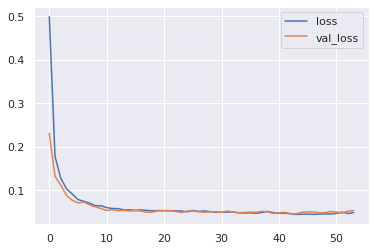

In [598]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### 2.6.4 Predict a single vector ahead.

Predicting a single vector ahead is actually making a h-step forecast.  This is done in exactly the same way as the other models using `.predict(X)`

In [665]:
#to understand why we include [0] on the end comment it out and rerun the code.
y_preds = model_v.predict(X_test[0].reshape(1, -1))[0]
y_preds

array([-1.1589744 , -0.89829755, -0.92750764, -0.79436636, -0.6314692 ,
       -0.4470132 , -0.23453347, -0.23258233, -0.05976303,  0.24490714,
        0.49312475,  0.6790571 ], dtype=float32)

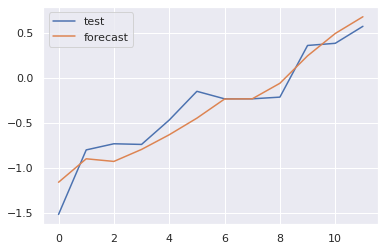

In [666]:
#plot the prediction
plt.plot(y_test[0], label='test')
plt.plot(y_preds, label='forecast')
plt.legend()

### 2.6.5 Exercise predicting multiple vectors ahead (> h-steps)

It is important to remember that with the vector output you predict in multiples of $h$.  So if you make two predictions you have predictions for 2h.  But in general this works in the same way as the iterative method.  Each time you forecast you replace $h$ values in the X vector with the predictions.

**Task**: 
* Modify `autoregressive_iterative_forecast` (provided below) so that it works with the new model.  After you are done rename the function `vector_iterative_forecast`
* Predict 4 vector lengths ahead and plot the result against the test set.

Hints:

* For simplicity, you could make the parameter `h` the number of vectors ahead to predict.
* Each call of `model.predict(X)` returns a vector.  At the end of the iterative forecast you will have a list of vectors.  Call `np.concatenate(list)` to transform this into a single list.
* In the notebook the X and vectors are both of size 12 (`WINDOW_SIZE == 12` and `len(y_train[0]) == 12`). This means you could simplify your code for the example.  Alternatively it could work with different sized X and y vectors. 
* Remember that `y_test` contains sliding windows of size 12.  So if you predict 2 vectors ahead then you will need to plot `y_test[0]` and `y_test[12]`




In [674]:
def vector_iterative_forecast(model, exog, h):
    '''
    h-step forecast for an autoregressive 
    model using the iterative prediction method.
    
    Conduct h one-step forecasts gradually
    replacing ground truth autoregressive X 
    values with predictions.
    
    Parameters:
    ------
    model: forecast object
        model that has a .predict(h) interface
        
    exog: array-like
        initial vector of lagged values (X)
    
    h: int
        forecast horizon. assumed to be > 0
    
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    y_preds = []
    current_X = exog
    for i in range(h):
        y_pred = model.predict(current_X.reshape(1, -1))[0]
        y_preds.append(y_pred)
        
        #current_X = np.roll(current_X, shift=-h)
        #current_X[-h] = y_pred.copy()
        current_X = y_pred.copy()

    return np.concatenate(np.array(y_preds))

In [676]:
H=4
y_preds = vector_iterative_forecast(model_v, X_test[0], H)
y_preds

array([-1.1589744 , -0.89829755, -0.92750764, -0.79436636, -0.6314692 ,
       -0.4470132 , -0.23453347, -0.23258233, -0.05976303,  0.24490714,
        0.49312475,  0.6790571 ,  0.80547893,  0.9203242 ,  0.86140823,
        1.0921426 ,  1.0867629 ,  0.8776909 ,  0.886359  ,  0.62573785,
        0.582631  ,  0.30832008,  0.13442019, -0.07194352, -0.30973226,
       -0.39227048, -0.5982545 , -0.66581655, -0.79492944, -0.90289104,
       -0.9851315 , -0.96397084, -0.8960377 , -0.8374568 , -0.74016637,
       -0.570248  , -0.4941451 , -0.34884834, -0.1830155 ,  0.06016677,
        0.20185442,  0.33131245,  0.576006  ,  0.64466214,  0.79209936,
        0.8749446 ,  0.9937673 ,  0.8755938 ], dtype=float32)

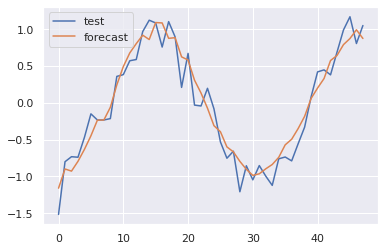

In [677]:
y_test_to_plot = []
for i in range(H):
    y_test_to_plot.append(y_test[WINDOW_SIZE*i])

plt.plot(np.concatenate(y_test_to_plot), label='test')
plt.plot(y_preds, label='forecast')
plt.legend()

## 3. Forecasting emergency admissions in England

We will now use a feedforward neural networks to predict the number of monthly emergency admissions in England. 

In [478]:
url = 'https://raw.githubusercontent.com/health-data-science-OR/data/master/em_admits_ts.csv'
em_admits = pd.read_csv(url)

In [479]:
em_admits.head(3)

,month_year,em_admits
0,Aug-10,425702
1,Sep-10,424900
2,Oct-10,436215


In [480]:
em_admits.shape

(111, 2)

## 3.1 Preprocessing

### 3.1.1 Datetime format

Notice the the `month_year` column holds a string an odd date format e.g. 'Aug-10'.  Pandas cannot cope with this as-is because '10' could refer to any century!  So let's do a bit of preprocessing to get it into datetime format.

First we will format the string to something pandas can parse i.e. 'Aug 2010'.  Then we will call the `pd.to_datetime()` function to parse the string and return a `datetime`.  We will assign the result to our dataframe's index and set the freq to monthly start 'MS'

In [481]:
date_str = em_admits['month_year'].str[:3] + ' 20' + em_admits['month_year'].str[-2:]
date_str.name = 'date'
em_admits = em_admits.set_index(pd.to_datetime(date_str))
em_admits.index.freq = 'MS'
em_admits = em_admits.drop(columns=['month_year'])

In [483]:
em_admits.head()

,em_admits
date,
2010-08-01,425702
2010-09-01,424900
2010-10-01,436215
2010-11-01,429099
2010-12-01,452728


We will be forecasting the last 12 months of the series.  Let's take a look at the training data (being careful to exclude the last 12 months)

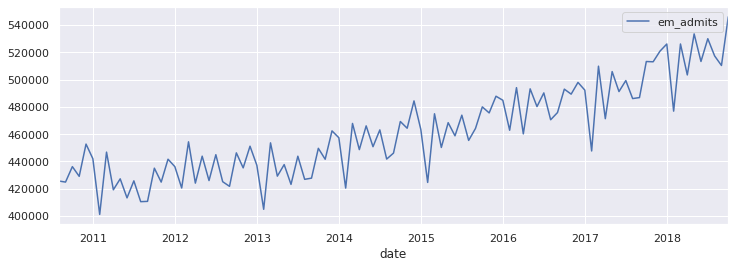

In [484]:
em_admits[:len(em_admits)-12].plot(figsize=(12,4))

### 3.1.2 Calender adjustment

This is monthly data so a useful preprocessing step is to transform the data into a daily rate by dividing by the number of days in the month. When we plot this the troughs we saw in Feb each year disappear.

In [486]:
admit_rate = em_admits['em_admits'] / em_admits.index.days_in_month

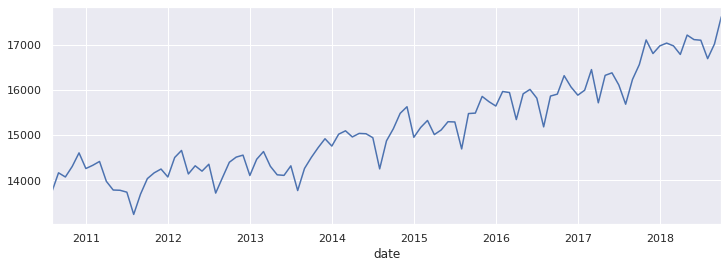

In [488]:
admit_rate[:len(admit_rate)-12].plot(figsize=(12,4));

### 3.1.3 Tabular data and train-test split

In [181]:
#for clarity repeat the preprocessing
X_train, y_train = sliding_window(admit_rate, window_size=12)

In [182]:
test_length = 12
X_train, y_train = X_train[:len(X_train) - 12], y_train[:len(X_train) - 12]
X_test, y_test = X_train[len(X_train) - 12:], y_train[len(X_train) - 12:]

### 3.1.4 Scaling the features and target to be between -1 and 1

In lot's of machine learning applications data are scaled to be between 0 and 1.  For neural network forecasting, Ord, Fildes and Kourentzes recommend scaling to be between -1 and 1.  This is what we will do here.  To do the scaling we will use

```python
sklearn.preprocessing.MinMaxScaler
```

In [491]:
from sklearn.preprocessing import MinMaxScaler

In [184]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [492]:
#I am scaling on admit_rate because this will include the first 12 lags 
#not in y_train
scaler.fit(admit_rate.iloc[:-12].to_numpy().reshape(-1, 1))

MinMaxScaler(feature_range=(-1, 1))

In [186]:
y_train = scaler.transform(y_train.reshape(-1, 1))
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_test = scaler.transform(y_test.reshape(-1, 1))

## 3.2 Training a Network that mimics the Linear Model

The first model we will try is the linear model.  Its a good neural network baseline to see if we can improve on it.

In [493]:
#set tensorflow random seed for repeatability
tf.random.set_seed(1234)

N_EPOCHS = 100
es = EarlyStopping(monitor='val_loss', patience=10)

#call the linear model function create earlier.
model_lm = get_linear_model(ws=12, metrics=['mae'])

#fit model silently (verbose=0)
history = model_lm.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    callbacks=[es])

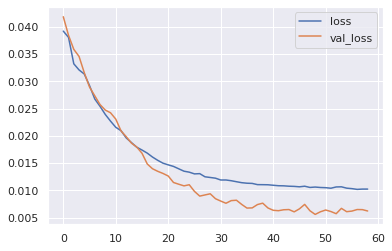

In [494]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

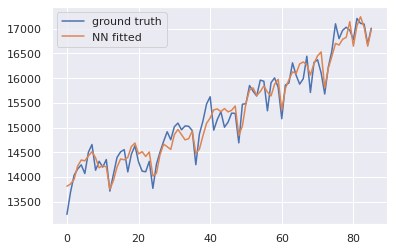

In [495]:
plt.plot(scaler.inverse_transform(y_train), label='ground truth')
plt.plot(scaler.inverse_transform(model_lm.predict(X_train)), label='NN fitted')
plt.legend();

In [496]:
def plot_nn_prediction_results(model, X_train, y_train, y_test, y_preds):  
    
    #create series
    fitted_values = scaler.inverse_transform(model.predict(X_train))
    ground_truth = scaler.inverse_transform(y_train)
    ground_truth_val = scaler.inverse_transform(y_test)

    padding = np.full(len(fitted_values), np.NAN)

    validation = np.concatenate([padding.reshape(-1, 1), ground_truth_val])
    forecast = np.concatenate([padding.reshape(-1, 1), y_preds])

    plt.plot(ground_truth, label='ground truth')
    plt.plot(validation, label='test')
    plt.plot(fitted_values, label='in-sample', linestyle='-.')
    plt.plot(forecast, label='out-of-sample', linestyle='-.')
    plt.legend();

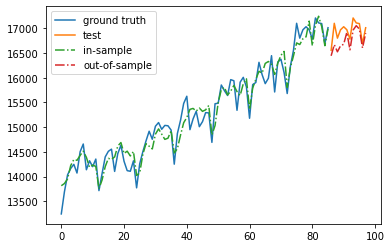

In [206]:
#predict next 12 months and plot
H = 12
y_preds_lm = autoregressive_iterative_forecast(model_lm, X_test[0], h=H)
y_preds_lm = scaler.inverse_transform(y_preds_lm.reshape(-1, 1))

plot_nn_prediction_results(model, X_train, y_train, y_test, y_preds_lm)

In [248]:
def get_network_model(ws, n_neurons_l1=32, n_neurons_l2=64,
                      include_layer_two=False, 
                      lr=0.01, metrics=None):
    if metrics is None:
        metrics = ['mse']
        
    model = Sequential()
    model.add(Flatten(input_shape=(ws,)))
    model.add(Dense(n_neurons_l1, activation='relu'))
    if include_layer_two:
        model.add(Dense(n_neurons_l2, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', 
                  optimizer=Adam(lr=lr),
                  metrics=metrics)
    return model

In [285]:
#set tensorflow random seed
tf.random.set_seed(45676)

N_EPOCHS = 100
es = EarlyStopping(monitor='loss', patience=10)

#single layer nn
mlp = get_network_model(ws=12, n_neurons_l1=32)

#fit model silently
history = mlp.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    verbose=0, callbacks=[es])

rmse lm: 232.65
rmse mlp: 98.50


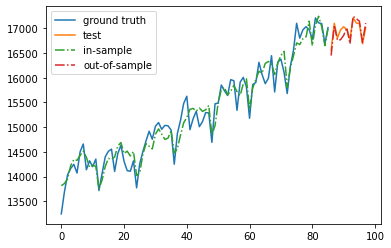

In [287]:
#predict next 12 months and plot
H = 12
y_preds_mlp = autoregressive_iterative_forecast(mlp, X_test[0], h=H)
y_preds_mlp = scaler.inverse_transform(y_preds_mlp.reshape(-1, 1))

plot_nn_prediction_results(model, X_train, y_train, y_test, y_preds_mlp)

rmse_lm = rmse(scaler.inverse_transform(y_test), y_preds_lm)[0]
rmse_mlp = rmse(scaler.inverse_transform(y_test), y_preds_mlp)[0]

print(f'rmse lm: {rmse_lm:.2f}\nrmse mlp: {rmse_mlp:.2f}')

rmse lm: 232.65
rmse mlp: 63.90


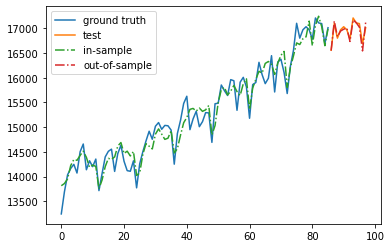

In [293]:
#try changing the network parameters to see the impact on the 
#rmse relative to the linear model

#set tensorflow random seed
tf.random.set_seed(45676)

N_EPOCHS = 100
H = 12
es = EarlyStopping(monitor='loss', patience=10)

#single layer nn
mlp = get_network_model(ws=12, 
                        n_neurons_l1=32,
                        include_layer_two=True,
                        n_neurons_l2=64,
                        lr=0.01)

#fit model silently
history = mlp.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    verbose=0, callbacks=[es])

y_preds_mlp = autoregressive_iterative_forecast(mlp, X_test[0], h=H)
y_preds_mlp = scaler.inverse_transform(y_preds_mlp.reshape(-1, 1))

rmse_lm = rmse(scaler.inverse_transform(y_test), y_preds_lm)[0]
rmse_mlp = rmse(scaler.inverse_transform(y_test), y_preds_mlp)[0]

print(f'rmse lm: {rmse_lm:.2f}\nrmse mlp: {rmse_mlp:.2f}')

plot_nn_prediction_results(model, X_train, y_train, y_test, y_preds_mlp)

# Ensemble Learning

In all of the examples above we have been setting a random seed for tensorflow.  This 'suggests' that if we used a different randon number seed we would get a slightly different result.  One of the problems with neural networks is overfitting.  There are multiple ways to deal with overfitting.  In forecasting a common approach is to use an **ensemble** of models.  

In an ensemble we train multiple models. 

## Training an ensemble

We will train an ensemble of neural networks that mimic a linear model.  

In [680]:
def load_models(n_models):
    models = []
    for n in range(n_models):
        model_n = tf.keras.models.load_model(f'output/ensemble_model_{n}.h5')
        models.append(model_n)
    return models

In [681]:
#set random seed so that ensemble can be repeated.
tf.random.set_seed(1085)

N_MODELS = 50
N_EPOCHS = 100
WINDOW_SIZE = 12
es = EarlyStopping(monitor='loss', patience=10)

#I've pretrained 50 models you can load them from file if wanted.
LOAD_FROM_FILE = True

if LOAD_FROM_FILE:
    #it will take a few seconds to load.
    models = load_models(N_MODELS)
else:
    models = []
    for n in range(N_MODELS):
        #single layer nn
        model_n = get_linear_model(WINDOW_SIZE)

        #fit model silently
        history = model_n.fit(x=X_train, 
                              y=y_train, 
                              epochs=N_EPOCHS,
                              verbose=0, 
                              callbacks=[es], 
                              batch_size=32)

        #this will overwrite pre-trained models.
        model_n.save(f'output/ensemble_model_{n}.h5')
        models.append(model_n)

### Predictions in an ensemble

In an ensemble we predict in a loop. In python this is straightfoward as we simply loop through the models we have trained and call `autoregressive_iterative_forecast`. Store the predictions of each forecast in a python `list`  called `e_preds`

In [684]:
#this code will take a few seconds to execute
H = 12
e_preds = []
for model in models:
    y_preds = autoregressive_iterative_forecast(model, X_test[0], h=H)
    e_preds.append(y_preds)
    
e_preds = np.array(e_preds)

Inverse transform the data and calculate the median and 0.025 and 0.975 percentiles of the point forecasts

Remember we can use `scaler.inverse_transform()`

In [685]:
e_preds = np.asarray(e_preds)
e_preds_tran = scaler.inverse_transform(e_preds).T
y_preds_mdn = np.percentile(e_preds_tran.T, 50, axis=0)
y_preds_2_5 = np.percentile(e_preds_tran.T, 2.5, axis=0)
y_preds_97_5 = np.percentile(e_preds_tran.T, 97.5, axis=0)
y_preds_mdn.shape

(12,)

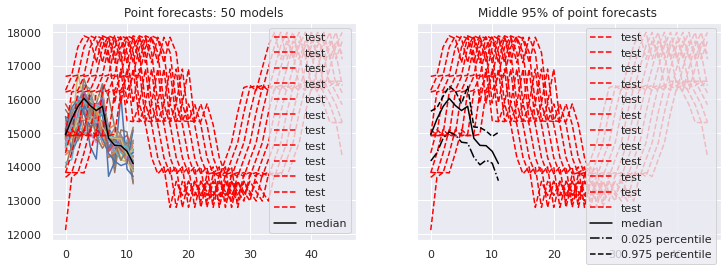

In [686]:
#plot the individual forecasts and the median

fig,ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
ax[0].plot(e_preds_tran)
ax[0].plot(scaler.inverse_transform(y_test), label='test', linestyle='--', 
         color='red')
ax[0].plot(y_preds_mdn, label='median', linestyle='-', color='black')
ax[0].legend()
ax[0].set_title(f'Point forecasts: {N_MODELS} models')

ax[1].plot(scaler.inverse_transform(y_test), label='test', linestyle='--', 
         color='red')
ax[1].plot(y_preds_mdn, label='median', linestyle='-', color='black')
ax[1].plot(y_preds_2_5, label='0.025 percentile', linestyle='-.', color='black')
ax[1].plot(y_preds_97_5, label='0.975 percentile', linestyle='--', color='black')
#ax[1].plot(y_preds_lm, label='original lmforecast', linestyle='--', color='green')
ax[1].set_title(f'Middle 95% of point forecasts ')
ax[1].legend();

In [467]:
rmse_lm = rmse(scaler.inverse_transform(y_test), y_preds_lm)[0]
rmse_mdn = rmse(scaler.inverse_transform(y_test), y_preds_mdn)[0]

print(f'rmse lm: {rmse_lm:.2f}\nrmse ensemble: {rmse_mdn:.2f}')

rmse lm: 232.65
rmse ensemble: 579.12


In [468]:
rmse_25 = rmse(scaler.inverse_transform(y_test), y_preds_25)[0]
rmse_75 = rmse(scaler.inverse_transform(y_test), y_preds_75)[0]
print(f'95% of linear models will have rmse between: {rmse_75:.2f} - {rmse_25:.2f}')

95% of linear models will have rmse between: 305.72 - 884.97


So were the original linear model results just a fluke due to the choice of seed?  
Let's try another seed to find out.

In [469]:
#set tensorflow random seed for repeatability
#try multiple seeds
tf.random.set_seed(1066)

N_EPOCHS = 100
es = EarlyStopping(monitor='val_loss', patience=10)

#compile the tf model
model_lm = get_linear_model(ws=12, metrics=['mae'])

#fit model silently
history = model_lm.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    batch_size=32,
                    callbacks=[es])

rmse lm: 232.65
rmse lm2: 466.79


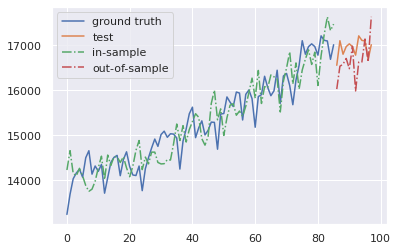

In [470]:
#predict next 12 months and plot
H = 12
y_preds_lm2 = autoregressive_iterative_forecast(model_lm, X_test[0], h=H)
y_preds_lm2 = scaler.inverse_transform(y_preds_lm2.reshape(-1, 1))

plot_nn_prediction_results(model_lm, X_train, y_train, y_test, y_preds_lm2)

rmse_lm = rmse(scaler.inverse_transform(y_test), y_preds_lm)[0]
rmse_lm2 = rmse(scaler.inverse_transform(y_test), y_preds_lm2)[0]

print(f'rmse lm: {rmse_lm:.2f}\nrmse lm2: {rmse_lm2:.2f}')

## Extra credit.
* How would you use a ensemble method with the direct forecasting method?